In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helper_functions_elliot as hfe # Elliot's helper function
import windrose as wr # Creates plots of windroses
from scipy import stats
import math

## Data Reading

In [4]:
# Read in all data files and rename attributes to similar format
boom1 = pd.read_csv("data/Boom1OneMin.csv")
boom1.rename(columns = {'TimeStamp':'time',
                        'MeanVelocity (m/s)':'meanVel6',
                       'MeanDirection':'meanDir6',
                       'MeanTemperature (C )':'meanTemp6',
                       'MeanPressure (mmHg)':'meanPres6'},inplace=True)
boom2 = pd.read_csv("data/Boom2OneMin-2.csv")
boom2.rename(columns = {'TIMESTAMP':'time',
                        'MeanVelocity (m/s)':'meanVel10',
                       'MeanDirection':'meanDir10',
                       'MeanTemperature (C )':'meanTemp10',
                       'MeanRH (%)':'meanRH10'},inplace=True)
boom3 = pd.read_csv("data/Boom3OneMin.csv")
boom3.rename(columns = {'TIMESTAMP':'time',
                        'MeanVelocity (m/s)':'meanVel20',
                       'MeanDirection':'meanDir20'},inplace=True)
boom4 = pd.read_csv("data/Boom4OneMin.csv")
boom4.rename(columns = {'TimeStamp':'time',
                        'MeanVelocity':'meanVel32',
                       'MeanDirection':'meanDir32',
                       'MeanTemperature':'meanTemp32',
                       'MeanRH':'meanRH32'},inplace=True)
boom5 = pd.read_csv("data/Boom5OneMin.csv")
boom5.rename(columns = {'TimeStamp':'time',
                        'MeanVelocity':'meanVel80',
                       'MeanDirection':'meanDir80',
                       'MeanTemperature':'meanTemp80',
                       'MeanRH':'meanRH80'},inplace=True)
boom6 = pd.read_csv("data/Boom6OneMin-2.csv")
boom6.rename(columns = {'TIMESTAMP':'time',
                        'MeanVelocity (m/s)':'meanVel106W',
                       'Mean Direction':'meanDir106W',
                       'MeanTemperature (C )':'meanTemp106W',
                       'MeanRH (%)':'meanRH106W'},inplace=True)
boom7 = pd.read_csv("data/Boom7OneMin.csv")
boom7.rename(columns = {'TimeStamp':'time',
                        'MeanVelocity (m/s)':'meanVel106E',
                       'MeanDirection':'meanDir106E',
                       'MeanPressure (mmHg)':'meanPres106E'},inplace=True)

## Data Cleaning

In [5]:
boomList = [boom1,boom2,boom3,boom4,boom5,boom6,boom7]
for i in range(0,len(boomList)):
    boomList[i]['time'] = pd.to_datetime(boomList[i]['time']) # Format all date-times the same way

In [6]:
# Merge all dataframes to get all height-based attributes for each time
wind = pd.merge(boom1, boom2, how = 'inner', on = 'time')
wind = wind.merge(boom3, how = 'inner', on = 'time')
wind = wind.merge(boom4, how = 'inner', on = 'time')
wind = wind.merge(boom5, how = 'outer', on = 'time') # Outer join bc boom 5 is missing much data
wind = wind.merge(boom6, how = 'inner', on = 'time')
wind = wind.merge(boom7, how = 'inner', on = 'time')

In [7]:
heights = [6,10,20,32,80,'106E','106W']
for h in heights:
    wind[f'meanDir{h}'] = (wind[f'meanDir{h}'] - 90) % 360 # Correct the angles

In [8]:
wind['meanDir106'] = np.zeros(len(wind)) # Set only one direction for 106m
averageDir = (wind['meanDir106E'] + wind['meanDir106W']) / 2
for i in range(len(wind)):
    if averageDir[i] < 180:
        wind['meanDir106'][i] = wind['meanDir106E'][i] # Wind is coming from the east, use east boom
    else:
        wind['meanDir106'][i] = wind['meanDir106W'][i] # Wind is coming from the west, use west boom
wind.drop(columns = ['meanDir106E','meanDir106W'], inplace = True) # Drop useless vel/dir attributes

is260_280 = (wind['meanDir106'] < 280) & (wind['meanDir106'] > 260)
is70_110 = (wind['meanDir106'] < 110) & (wind['meanDir106'] > 70)
wind['meanVel106'] = np.zeros(len(wind)) # Set one velocity for 106m
for i in range(len(wind)): # For each time, find most accurate velocity by either averaging between east and west booms, or picking the windward side due to shadow effect in certain sectors
    if is260_280[i]:
        wind['meanVel106'][i] = wind['meanVel106W'][i]
    elif is70_110[i]:
        wind['meanVel106'][i] = wind['meanVel106E'][i]
    else:
        wind['meanVel106'][i] = np.mean([wind['meanVel106W'][i], wind['meanVel106E'][i]]) 
wind.head(2)

C:\Users\Hudson\AppData\Local\Temp\ipykernel_3196\211258028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind['meanDir106'][i] = wind['meanDir106E'][i] # Wind is coming from the east, use east boom
C:\Users\Hudson\AppData\Local\Temp\ipykernel_3196\211258028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind['meanDir106'][i] = wind['meanDir106W'][i] # Wind is coming from the west, use west boom
C:\Users\Hudson\AppData\Local\Temp\ipykernel_3196\211258028.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

,time,meanVel6,meanDir6,meanTemp6,meanPres6,meanVel10,meanDir10,meanTemp10,meanRH10,meanVel20,...,meanDir80,meanTemp80,meanRH80,meanVel106W,meanTemp106W,meanRH106W,meanVel106E,meanPres106E,meanDir106,meanVel106
0,2017-09-22 00:01:00,4.664167,157.784333,25.374333,736.912500,4.99,154.09,25.21,75.17,5.81,...,166.72,25.08,74.52,9.58,24.92,73.53,9.925167,728.880833,174.110000,9.752583
1,2017-09-22 00:02:00,4.235000,153.324667,25.344833,736.897167,4.94,154.67,25.10,75.30,5.54,...,161.23,25.21,74.16,9.94,24.95,73.45,9.548333,728.945833,170.694833,9.744167


In [9]:
wind.set_index('time',inplace=True) # Reset the index to time

In [10]:
heights = [6,10,20,32,80,106] #this is if we wanted to average all height vectors
#heights = [10,106] # df with only relevant attributes
for h in heights:
    dirRad = np.deg2rad(wind[f'meanDir{h}']) # Convert degrees to radians
    wind[f'x_{h}'] = wind[f'meanVel{h}'] * np.sin(dirRad) # Get horizontal component of wind vector. Angle is from north.
    wind[f'y_{h}'] = wind[f'meanVel{h}'] * np.cos(dirRad) # Get vertical component of wind vector
np.sum(np.isnan(wind['x_106']))  
len(wind)

392884

In [11]:
windSTD = wind.fillna(wind.mean()) # Fill nan with mean
windSTD = stats.zscore(windSTD) # Find z-scores
wind = wind[~(windSTD > 5).any(axis=1)] # Only keep rows whose attribute's standard deviations are less than 5 using boolean indexing
len(wind) # Dropped 1429 rows

391455

In [12]:
# Take average of attributes for 10 consecutive minute data points. 
# Note that return is Nan if any data point in interval is nan or if a time in the interval is missing (non-consecutive) 
wind = wind.resample('10T').mean()
np.sum(np.isnan(wind['x_106']))

8788

In [13]:
for h in heights:
    wind[f'meanVel{h}'] = np.sqrt(wind[f'x_{h}']**2 + wind[f'y_{h}']**2) # Find velocity of averaged vector
    wind[f'meanDir{h}'] = (np.rad2deg(np.arctan2(wind[f'x_{h}'], wind[f'y_{h}'])) + 360) % 360 # Use vector components to find angle
    wind.drop(columns = [f'x_{h}',f'y_{h}'], inplace = True) # Drop useless component attributes

In [14]:
# Drop nan data points
wind = wind.dropna(subset=['meanPres6', 'meanPres106E', 'meanTemp10', 'meanTemp106W', 'meanRH10', 'meanRH106W', 'meanVel10', 'meanDir10', 'meanVel106', 'meanDir106'])
np.sum(np.isnan(wind['meanVel106'])), len(wind)

(0, 28649)

In [15]:
wind.head()

,meanVel6,meanDir6,meanTemp6,meanPres6,meanVel10,meanDir10,meanTemp10,meanRH10,meanVel20,meanDir20,...,meanDir80,meanTemp80,meanRH80,meanVel106W,meanTemp106W,meanRH106W,meanVel106E,meanPres106E,meanDir106,meanVel106
time,,,,,,,,,,,,,,,,,,,,,
2017-09-22 00:00:00,4.872980,157.160058,25.279019,736.874907,5.374339,156.455753,25.136667,75.338889,6.062302,161.485331,...,163.186889,25.127778,74.521111,9.508889,24.877778,73.921111,9.435130,728.916574,174.019930,9.463870
2017-09-22 00:10:00,4.650806,160.445942,25.240733,736.892067,5.259133,158.719583,25.114000,75.630000,5.876254,161.264952,...,163.565352,25.000000,75.192000,9.215000,24.764000,74.588000,9.024933,728.926017,173.311117,9.110358
2017-09-22 00:20:00,4.815703,158.367096,25.145600,736.908133,5.239524,157.034506,25.000000,75.892000,5.881022,159.957428,...,162.398428,24.979000,75.053000,9.628000,24.795000,74.358000,9.447083,728.882950,174.044646,9.532859
2017-09-22 00:30:00,4.378572,157.180067,25.061567,736.891917,4.792911,155.431055,24.882000,76.222000,5.625591,158.079573,...,162.038991,24.945000,75.165000,9.149000,24.697000,74.595000,9.090133,728.955450,172.927863,9.108679
2017-09-22 00:40:00,4.555818,157.064334,24.950567,736.888200,5.046848,156.252672,24.855000,76.438000,5.817678,158.693431,...,160.754123,24.776000,75.589000,9.116000,24.681000,74.640000,8.960733,728.986717,171.567157,9.030404


## Bulk Richardson's Number

In [17]:
# Get richardson number for one data point
def BRN10(wind):
    P1 = wind['meanPres6'] # Pressure (mmHg) *Note were using pressure at boom 1 to approximate pressure at boom 2
    P2 = wind['meanPres106E']
    T1 = wind['meanTemp10'] + 273.15 # Temperature (K)
    T2 = wind['meanTemp106W'] + 273.15
    RH1 = wind['meanRH10'] # Relative humidity (%)
    RH2 = wind['meanRH106W']
    vpt1 = hfe.virtual_potential_temperature(RH1, P1, T1) # Get vpt
    vpt2 = hfe.virtual_potential_temperature(RH2, P2, T2)
    z1 = 6
    z2 = 106
    ws1 = wind['meanVel10'] # Wind speed at 10m
    wd1 = wind['meanDir10'] # Wind dir at 10m
    ws2 = wind['meanVel106'] # Wind speed at 106m
    wd2 = wind['meanDir106'] # Wind dir at 106m
    return hfe.bulk_richardson_number(vpt1, vpt2, z1, z2, ws1, ws2, wd1, wd2) # Get bulk richardson number (BRN)

In [18]:
# Get vector of BRN for entire dataset (remember its in 10min averages)
def BRN_vec(wind):
    length = len(wind)
    BRN = np.zeros(length) # Placeholder vector of zeros

    for i in range(length):
        wind_10 = wind.iloc[i] # Select data point
        BRN[i] = BRN10(wind_10) # Fill vector with BRN

    return BRN

In [19]:
BRN = BRN_vec(wind) # Utilize function

C:\Users\Hudson\GLWind\helper_functions_elliot.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  ri = g * delta_vpt * delta_z / (vpt_avg * (delta_u * delta_u + delta_v * delta_v))


In [20]:
# BRN classifications (Newman and Klein 2014)
unstable = np.sum(BRN < -.1)
neutral = np.sum((-.1 < BRN) & (BRN < .1))
stable = np.sum((.1 < BRN) & (BRN < .25))
strongly_stable = np.sum(BRN > .25)

In [21]:
# Validation that we havent lost data
unstable + neutral + stable + strongly_stable

28649

Text(0, 0.5, 'frequency')

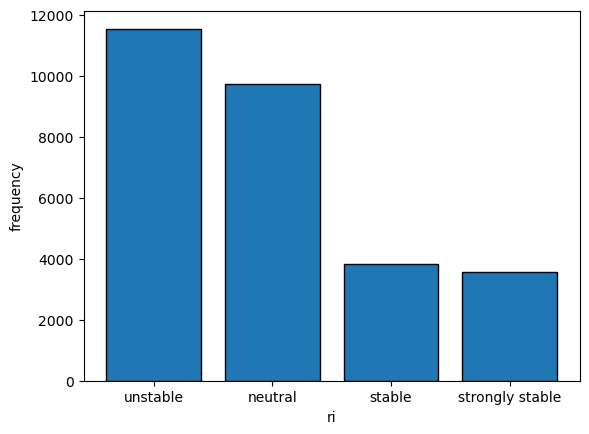

In [22]:
# Bar graph of the frequency of each category
plt.bar(['unstable','neutral','stable','strongly stable'],[unstable,neutral,stable,strongly_stable],edgecolor='black')
plt.xlabel('ri')
plt.ylabel('frequency')

## Windrose

In [23]:
# Concatenate all wind directions and speeds across all heights
direction = np.array(list(wind['meanDir6']) + list(wind['meanDir10']) + list(wind['meanDir20']) + list(wind['meanDir80']) + list(wind['meanDir106']))
speed = np.array(list(wind['meanVel6']) + list(wind['meanVel10']) + list(wind['meanVel20']) + list(wind['meanVel80']) + list(wind['meanVel106']))
direction = direction[~np.isnan(direction)]
speed = speed[~np.isnan(speed)]
len(direction), len(speed)

(117930, 117930)

In [24]:
np.sum(np.isnan(direction))

0

<WindroseAxes:>

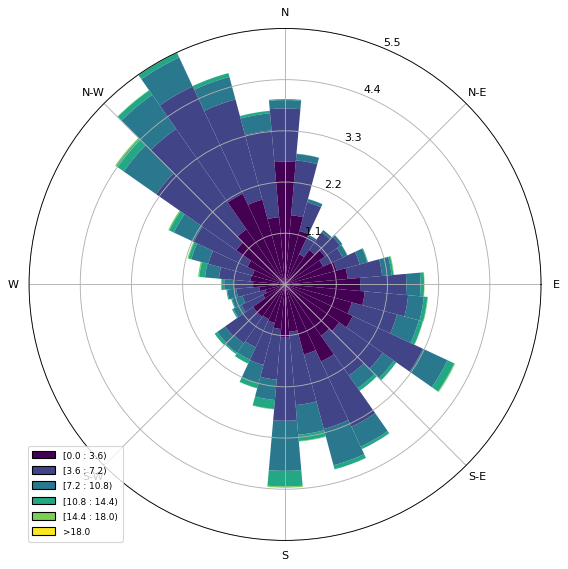

In [360]:
wr.wrbar(direction, speed, normed=True, nsector = 36, opening = 1)

## Data Stratification

In [25]:
wind['BRN'] = BRN # Create attribute for the BRN
wind.head(1)

,meanVel6,meanDir6,meanTemp6,meanPres6,meanVel10,meanDir10,meanTemp10,meanRH10,meanVel20,meanDir20,...,meanTemp80,meanRH80,meanVel106W,meanTemp106W,meanRH106W,meanVel106E,meanPres106E,meanDir106,meanVel106,BRN
time,,,,,,,,,,,,,,,,,,,,,
2017-09-22,4.87298,157.160058,25.279019,736.874907,5.374339,156.455753,25.136667,75.338889,6.062302,161.485331,...,25.127778,74.521111,9.508889,24.877778,73.921111,9.43513,728.916574,174.01993,9.46387,0.076246


In [137]:
wind['meanDirOverall'] = np.zeros(len(wind)) # Placeholder vector for 10 direction
heights = [6,10,20,32,106]
for h in heights:
    wind['meanDirOverall'] += wind[f'meanDir{h}'] # Sum all angles
wind['meanDirOverall'] = wind['meanDirOverall'] / len(heights) # Divide to find average across all heights
wind.head(2)

,meanVel6,meanDir6,meanTemp6,meanPres6,meanVel10,meanDir10,meanTemp10,meanRH10,meanVel20,meanDir20,...,meanRH80,meanVel106W,meanTemp106W,meanRH106W,meanVel106E,meanPres106E,meanDir106,meanVel106,BRN,meanDirOverall
time,,,,,,,,,,,,,,,,,,,,,
2017-09-22 00:00:00,4.872980,157.160058,25.279019,736.874907,5.374339,156.455753,25.136667,75.338889,6.062302,161.485331,...,74.521111,9.508889,24.877778,73.921111,9.435130,728.916574,174.019930,9.463870,0.076246,161.514556
2017-09-22 00:10:00,4.650806,160.445942,25.240733,736.892067,5.259133,158.719583,25.114000,75.630000,5.876254,161.264952,...,75.192000,9.215000,24.764000,74.588000,9.024933,728.926017,173.311117,9.110358,0.074285,162.001394


#### 10m Wind Direction

In [109]:
# Filter data into stability classes by BRN and sector (open or complex)
# Use 10m wind direction to filter data in sectors
z=[6,10,20,32,106]
wind = wind.drop(columns = 'meanDirOverall')

wind_unstable = wind.query('BRN < -0.1')
wind_unstable_complex = wind_unstable.query('300 < meanDir10 < 330')
wind_unstable_complex = wind_unstable_complex.mean()
wind_unstable_open = wind_unstable.query('120 < meanDir10 < 150')
wind_unstable_open = wind_unstable_open.mean(axis=0)
wind_unstable_complex['alpha'] = alpha_est(z,[wind_unstable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_unstable_complex['beta'] = beta_est(z,[wind_unstable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_unstable_open['alpha'] = alpha_est(z,[wind_unstable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_unstable_open['beta'] = beta_est(z,[wind_unstable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

wind_neutral = wind.query('-0.1 < BRN < 0.1')
wind_neutral_complex = wind_neutral.query('300 < meanDir10 < 330')
wind_neutral_complex = wind_neutral_complex.mean()
wind_neutral_open = wind_neutral.query('120 < meanDir10 < 150')
wind_neutral_open = wind_neutral_open.mean()
wind_neutral_complex['alpha'] = alpha_est(z,[wind_neutral_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_neutral_complex['beta'] = beta_est(z,[wind_neutral_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_neutral_open['alpha'] = alpha_est(z,[wind_neutral_open[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_neutral_open['beta'] = beta_est(z,[wind_neutral_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

wind_stable = wind.query('0.1 < BRN < 0.25')
wind_stable_complex = wind_stable.query('300 < meanDir10 < 330')
wind_stable_complex = wind_stable_complex.mean()
wind_stable_open = wind_stable.query('120 < meanDir10 < 150')
wind_stable_open = wind_stable_open.mean()
wind_stable_complex['alpha'] = alpha_est(z,[wind_stable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_stable_complex['beta'] = beta_est(z,[wind_stable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_stable_open['alpha'] = alpha_est(z,[wind_stable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_stable_open['beta'] = beta_est(z,[wind_stable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

wind_strongly_stable = wind.query('BRN > 0.25')
wind_strongly_stable_complex = wind_strongly_stable.query('300 < meanDir10 < 330')
wind_strongly_stable_complex = wind_strongly_stable_complex.mean()
wind_strongly_stable_open = wind_strongly_stable.query('120 < meanDir10 < 150')
wind_strongly_stable_open = wind_strongly_stable_open.mean()
wind_strongly_stable_complex['alpha'] = alpha_est(z,[wind_strongly_stable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_strongly_stable_complex['beta'] = beta_est(z,[wind_strongly_stable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_strongly_stable_open['alpha'] = alpha_est(z,[wind_strongly_stable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_strongly_stable_open['beta'] = beta_est(z,[wind_strongly_stable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

#### Overall Wind Direction Averages

In [138]:
# Filter data into stability classes by BRN and sector (open or complex)
# Take average of attributes under each condition
z=[6,10,20,32,106]

wind_unstable = wind.query('BRN < -0.1')
wind_unstable_complex = wind_unstable.query('300 < meanDirOverall < 330')
wind_unstable_complex = wind_unstable_complex.mean()
wind_unstable_open = wind_unstable.query('120 < meanDirOverall < 150')
wind_unstable_open = wind_unstable_open.mean(axis=0)
wind_unstable_complex['alpha'] = alpha_est(z,[wind_unstable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_unstable_complex['beta'] = beta_est(z,[wind_unstable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_unstable_open['alpha'] = alpha_est(z,[wind_unstable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_unstable_open['beta'] = beta_est(z,[wind_unstable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

wind_neutral = wind.query('-0.1 < BRN < 0.1')
wind_neutral_complex = wind_neutral.query('300 < meanDirOverall < 330')
wind_neutral_complex = wind_neutral_complex.mean() # find mean of all features for filtered data
wind_neutral_open = wind_neutral.query('120 < meanDirOverall < 150')
wind_neutral_open = wind_neutral_open.mean()
wind_neutral_complex['alpha'] = alpha_est(z,[wind_neutral_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_neutral_complex['beta'] = beta_est(z,[wind_neutral_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_neutral_open['alpha'] = alpha_est(z,[wind_neutral_open[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_neutral_open['beta'] = beta_est(z,[wind_neutral_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

wind_stable = wind.query('0.1 < BRN < 0.25')
wind_stable_complex = wind_stable.query('300 < meanDirOverall < 330')
wind_stable_complex = wind_stable_complex.mean()
wind_stable_open = wind_stable.query('120 < meanDirOverall < 150')
wind_stable_open = wind_stable_open.mean()
wind_stable_complex['alpha'] = alpha_est(z,[wind_stable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_stable_complex['beta'] = beta_est(z,[wind_stable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_stable_open['alpha'] = alpha_est(z,[wind_stable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_stable_open['beta'] = beta_est(z,[wind_stable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

wind_strongly_stable = wind.query('BRN > 0.25')
wind_strongly_stable_complex = wind_strongly_stable.query('300 < meanDirOverall < 330')
wind_strongly_stable_complex = wind_strongly_stable_complex.mean()
wind_strongly_stable_open = wind_strongly_stable.query('120 < meanDirOverall < 150')
wind_strongly_stable_open = wind_strongly_stable_open.mean()
wind_strongly_stable_complex['alpha'] = alpha_est(z,[wind_strongly_stable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_strongly_stable_complex['beta'] = beta_est(z,[wind_strongly_stable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_strongly_stable_open['alpha'] = alpha_est(z,[wind_strongly_stable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])
wind_strongly_stable_open['beta'] = beta_est(z,[wind_strongly_stable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

## Regression Analysis

In [139]:
# ln(U(z)) = ln(beta) + alpha*ln(z)
def alpha_est(z,U):
    #alpha = np.sum(np.log(z) - np.mean(np.log(z)) * (np.log(U) - np.mean(np.log(U)))) / np.sum((np.log(z) - np.mean(np.log(z)))**2)
    alpha = (len(z) * np.sum(np.log(U)*np.log(z)) - np.sum(np.log(z)) * np.sum(np.log(U))) / (len(z)*np.sum(np.log(z)**2) - np.sum(np.log(z))**2)
    if len(z) == 0:
        print(z,U,len(z)*np.sum(np.log(z)**2),np.sum(np.log(z))**2)
    return alpha

def beta_est(z,U):
    alpha_b = alpha_est(z,U)
    beta = np.mean(np.log(U)) - alpha_b * np.mean(np.log(z))
    return np.exp(beta)

In [140]:
def U_extrap(z,alpha,beta):
    U_extrap = beta * z**alpha
    return U_extrap

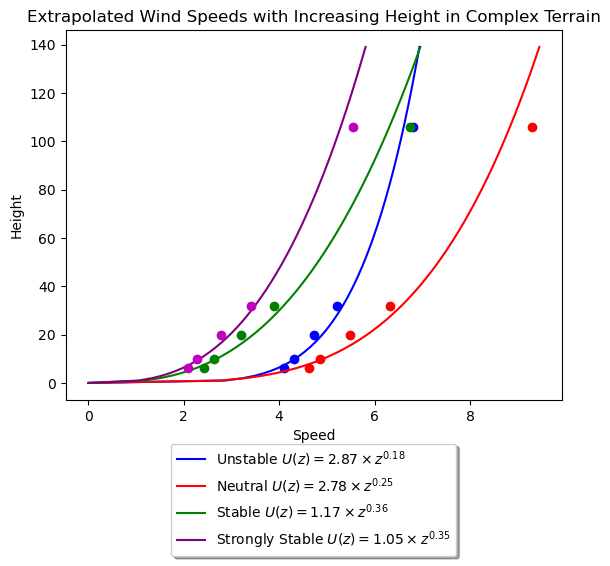

In [141]:
z = np.arange(0,140)

U_unstable_complex = U_extrap(z,wind_unstable_complex['alpha'],wind_unstable_complex['beta'])
z_emp = np.array([6,10,20,32,106])
U_emp_unstable_complex = np.array([wind_unstable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])

U_neutral_complex = U_extrap(z,wind_neutral_complex['alpha'],wind_neutral_complex['beta'])
U_emp_neutral_complex = np.array([wind_neutral_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])

U_stable_complex = U_extrap(z,wind_stable_complex['alpha'],wind_stable_complex['beta'])
U_emp_stable_complex = np.array([wind_stable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])

U_strongly_stable_complex = U_extrap(z,wind_strongly_stable_complex['alpha'],wind_strongly_stable_complex['beta'])
U_emp_strongly_stable_complex = np.array([wind_strongly_stable_complex[f'meanVel{h}'] for h in [6,10,20,32,106]])

alpha = wind_unstable_complex['alpha']
beta = wind_unstable_complex['beta']
plt.plot(U_unstable_complex, z, color='blue', label='Unstable ' r'$U(z) = %.2f \times z^{%.2f}$' % (beta, alpha))
plt.plot(U_emp_unstable_complex, z_emp,'bo')

alpha = wind_neutral_complex['alpha']
beta = wind_neutral_complex['beta']
plt.plot(U_neutral_complex, z, color='red', label='Neutral ' r'$U(z) = %.2f \times z^{%.2f}$' % (beta, alpha))
plt.plot(U_emp_neutral_complex, z_emp,'ro')

alpha = wind_stable_complex['alpha']
beta = wind_stable_complex['beta']
plt.plot(U_stable_complex, z, color='green', label='Stable ' r'$U(z) = %.2f \times z^{%.2f}$' % (beta, alpha))
plt.plot(U_emp_stable_complex, z_emp,'go')

alpha = wind_strongly_stable_complex['alpha']
beta = wind_strongly_stable_complex['beta']
plt.plot(U_strongly_stable_complex, z, color='purple', label='Strongly Stable ' r'$U(z) = %.2f \times z^{%.2f}$' % (beta, alpha))
plt.plot(U_emp_strongly_stable_complex, z_emp, 'mo')

plt.xlabel('Speed')
plt.ylabel('Height')
plt.title('Extrapolated Wind Speeds with Increasing Height in Complex Terrain')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=1)

plt.show()

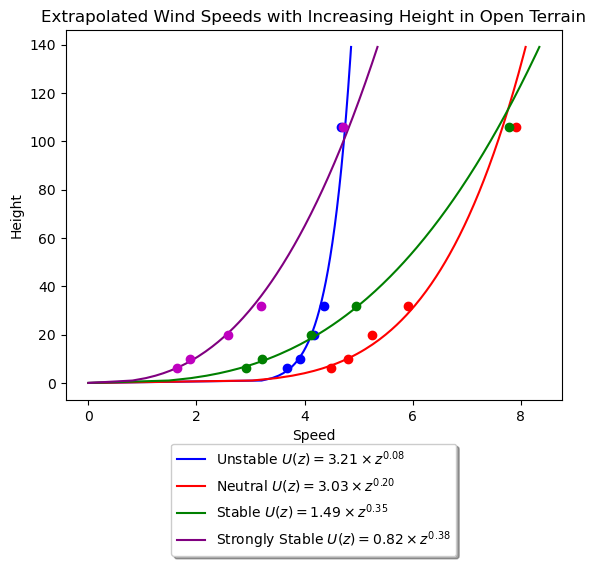

In [142]:
z = np.arange(0,140)

U_unstable_open = U_extrap(z,wind_unstable_open['alpha'],wind_unstable_open['beta'])
z_emp = np.array([6,10,20,32,106])
U_emp_unstable_open = np.array([wind_unstable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

U_neutral_open = U_extrap(z,wind_neutral_open['alpha'],wind_neutral_open['beta'])
U_emp_neutral_open = np.array([wind_neutral_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

U_stable_open = U_extrap(z,wind_stable_open['alpha'],wind_stable_open['beta'])
U_emp_stable_open = np.array([wind_stable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

U_strongly_stable_open = U_extrap(z,wind_strongly_stable_open['alpha'],wind_strongly_stable_open['beta'])
U_emp_strongly_stable_open = np.array([wind_strongly_stable_open[f'meanVel{h}'] for h in [6,10,20,32,106]])

alpha = wind_unstable_open['alpha']
beta = wind_unstable_open['beta']
plt.plot(U_unstable_open, z, color='blue', label='Unstable ' r'$U(z) = %.2f \times z^{%.2f}$' % (beta, alpha))
plt.plot(U_emp_unstable_open, z_emp,'bo')

alpha = wind_neutral_open['alpha']
beta = wind_neutral_open['beta']
plt.plot(U_neutral_open, z, color='red', label='Neutral ' r'$U(z) = %.2f \times z^{%.2f}$' % (beta, alpha))
plt.plot(U_emp_neutral_open, z_emp,'ro')

alpha = wind_stable_open['alpha']
beta = wind_stable_open['beta']
plt.plot(U_stable_open, z, color='green', label='Stable ' r'$U(z) = %.2f \times z^{%.2f}$' % (beta, alpha))
plt.plot(U_emp_stable_open, z_emp,'go')

alpha = wind_strongly_stable_open['alpha']
beta = wind_strongly_stable_open['beta']
plt.plot(U_strongly_stable_open, z, color='purple', label='Strongly Stable ' r'$U(z) = %.2f \times z^{%.2f}$' % (beta, alpha))
plt.plot(U_emp_strongly_stable_open, z_emp, 'mo')

plt.xlabel('Speed')
plt.ylabel('Height')
plt.title('Extrapolated Wind Speeds with Increasing Height in Open Terrain')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=1)

plt.show()

In [112]:
def alpha_vector(wind):
    length = len(wind)
    alpha_vec = np.zeros(length)
    for i in range(length):
        z = np.array([6,10,20,32,106]) # No 80m because of missing data
        U = np.array([wind['meanVel6'].iloc[i], wind['meanVel10'].iloc[i], wind['meanVel20'].iloc[i], wind['meanVel32'].iloc[i], wind['meanVel106'].iloc[i]])
        alpha_vec[i] = alpha_est(z,U)
    return alpha_vec

def beta_vector(wind):
    length = len(wind)
    beta_vec = np.zeros(length)
    for i in range(length):
        z = np.array([6,10,20,32,106])
        U = np.array([wind['meanVel6'].iloc[i], wind['meanVel10'].iloc[i], wind['meanVel20'].iloc[i], wind['meanVel32'].iloc[i], wind['meanVel106'].iloc[i]])
        beta_vec[i] = beta_est(z,U)
    return beta_vec

In [117]:
# Create alpha and beta values to regress each 10min period to a power curve
wind_10_unstable = wind_unstable
wind_10_unstable.loc[:,'alpha'] = alpha_vector(wind_10_unstable)

wind_10_neutral = wind_neutral
wind_10_neutral.loc[:,'alpha'] = alpha_vector(wind_10_neutral)

wind_10_stable = wind_stable
wind_10_stable.loc[:,'alpha'] = alpha_vector(wind_10_stable)

wind_10_strongly_stable = wind_strongly_stable
wind_10_strongly_stable.loc[:,'alpha'] = alpha_vector(wind_10_strongly_stable)

C:\Users\Hudson\AppData\Local\Temp\ipykernel_3196\3162929882.py:4: RuntimeWarning: divide by zero encountered in log
  alpha = (len(z) * np.sum(np.log(U)*np.log(z)) - np.sum(np.log(z)) * np.sum(np.log(U))) / (len(z)*np.sum(np.log(z)**2) - np.sum(np.log(z))**2)
C:\Users\Hudson\AppData\Local\Temp\ipykernel_3196\3162929882.py:4: RuntimeWarning: invalid value encountered in double_scalars
  alpha = (len(z) * np.sum(np.log(U)*np.log(z)) - np.sum(np.log(z)) * np.sum(np.log(U))) / (len(z)*np.sum(np.log(z)**2) - np.sum(np.log(z))**2)
C:\Users\Hudson\AppData\Local\Temp\ipykernel_3196\1497550589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_10_unstable.loc[:,'alpha'] = alpha_vector(wind_10_unstable)
C:\Users\Hudson\AppData\Local\Temp\ipykernel_3

In [ ]:
"""for i in range(len((wind_10_unstable['alpha']))):
    if np.isnan(wind_10_unstable['alpha'])[i] == True:
        print(i)"""

"for i in range(len((wind_10_unstable['alpha']))):\n    if np.isnan(wind_10_unstable['alpha'])[i] == True:\n        print(i)"

### Distributions of Alpha Across all Terrain

In [130]:
bins = np.arange(-.4, 1.4, .04)

Text(1, 5.5, 'Mean: 0.17\nMedian: 0.17\nStd Dev: 0.07\nSkew: 0.12')

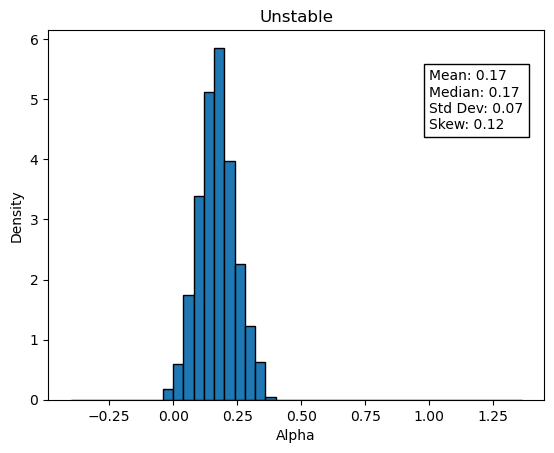

In [131]:
# removing outliers
arr = wind_10_unstable['alpha']
arr = arr.dropna()
Q1 = np.percentile(arr, 25)
Q3 = np.percentile(arr, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
unstable_alpha_dist = arr[(arr >= lower_bound) & (arr <= upper_bound)]

unstable_alpha_dist = unstable_alpha_dist[~np.isnan(unstable_alpha_dist)]
mean = np.mean(unstable_alpha_dist)
median = np.median(unstable_alpha_dist)
std_dev = np.std(unstable_alpha_dist)
skewness = np.mean((unstable_alpha_dist - mean) ** 3) / (std_dev ** 3)

plt.hist(unstable_alpha_dist,bins,edgecolor = 'black',density=True)
plt.title('Unstable')
plt.xlabel('Alpha')
plt.ylabel('Density')
plt.text(1, 5.5, f'Mean: {mean:.2f}\nMedian: {median:.2f}\nStd Dev: {std_dev:.2f}\nSkew: {skewness:.2f}',
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='black'))

Text(1, 5, 'Mean: 0.28\nMedian: 0.27\nStd Dev: 0.08\nSkew: 0.44')

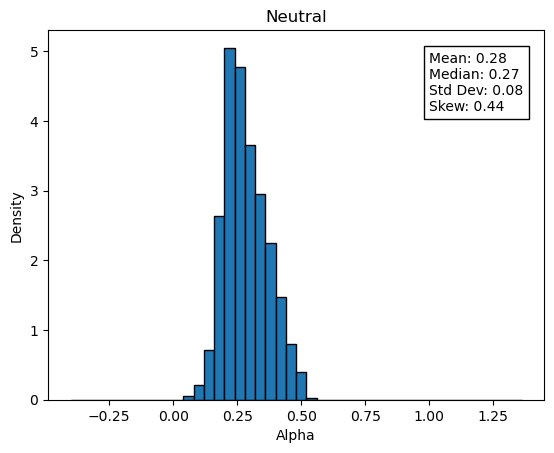

In [133]:
arr = wind_10_neutral['alpha']
arr = arr.dropna()
Q1 = np.percentile(arr, 25)
Q3 = np.percentile(arr, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
neutral_alpha_dist = arr[(arr >= lower_bound) & (arr <= upper_bound)]

neutral_alpha_dist = neutral_alpha_dist[~np.isnan(neutral_alpha_dist)]
mean = np.mean(neutral_alpha_dist)
median = np.median(neutral_alpha_dist)
std_dev = np.std(neutral_alpha_dist)
skewness = np.mean((neutral_alpha_dist - mean) ** 3) / (std_dev ** 3)

plt.hist(neutral_alpha_dist,bins,edgecolor = 'black',density=True)
plt.title('Neutral')
plt.xlabel('Alpha')
plt.ylabel('Density')
plt.text(1, 5, f'Mean: {mean:.2f}\nMedian: {median:.2f}\nStd Dev: {std_dev:.2f}\nSkew: {skewness:.2f}',
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='black'))

Text(1, 3, 'Mean: 0.42\nMedian: 0.42\nStd Dev: 0.12\nSkew: 0.23')

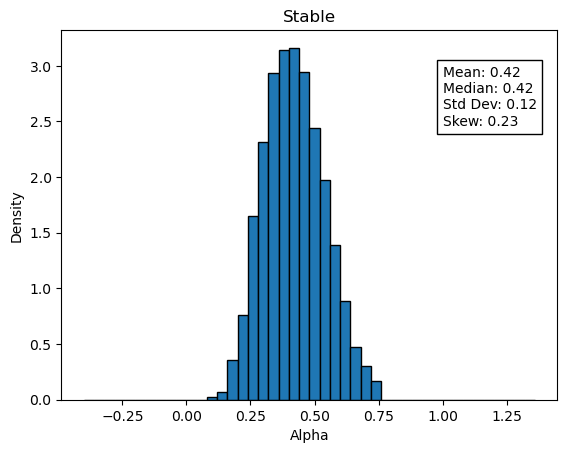

In [132]:
arr = wind_10_stable['alpha']
arr = arr.dropna()
Q1 = np.percentile(arr, 25)
Q3 = np.percentile(arr, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
stable_alpha_dist = arr[(arr >= lower_bound) & (arr <= upper_bound)]

stable_alpha_dist = stable_alpha_dist[~np.isnan(stable_alpha_dist)]
mean = np.mean(stable_alpha_dist)
median = np.median(stable_alpha_dist)
std_dev = np.std(stable_alpha_dist)
skewness = np.mean((stable_alpha_dist - mean) ** 3) / (std_dev ** 3)

plt.hist(stable_alpha_dist,bins,edgecolor = 'black',density=True)
plt.title('Stable')
plt.xlabel('Alpha')
plt.ylabel('Density')
plt.text(1, 3, f'Mean: {mean:.2f}\nMedian: {median:.2f}\nStd Dev: {std_dev:.2f}\nSkew: {skewness:.2f}',
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='black'))

Text(1, 2.1, 'Mean: 0.41\nMedian: 0.41\nStd Dev: 0.23\nSkew: 0.34')

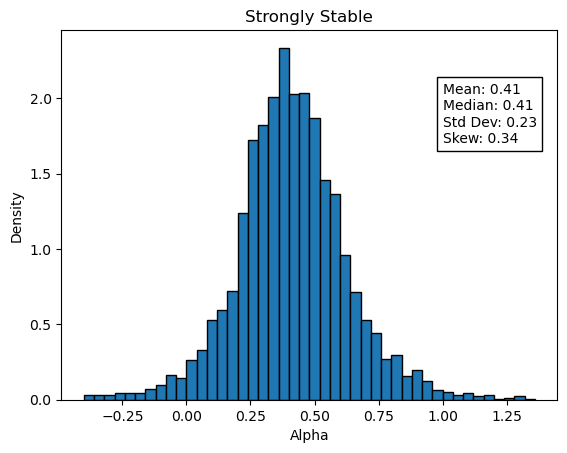

In [134]:
arr = wind_10_strongly_stable['alpha']
arr = arr.dropna()
Q1 = np.percentile(arr, 25)
Q3 = np.percentile(arr, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
strongly_stable_alpha_dist = arr[(arr >= lower_bound) & (arr <= upper_bound)]

strongly_stable_alpha_dist = wind_10_strongly_stable['alpha']
strongly_stable_alpha_dist = strongly_stable_alpha_dist[~np.isnan(strongly_stable_alpha_dist)]
mean = np.mean(strongly_stable_alpha_dist)
median = np.median(strongly_stable_alpha_dist)
std_dev = np.std(strongly_stable_alpha_dist)
skewness = np.mean((strongly_stable_alpha_dist - mean) ** 3) / (std_dev ** 3)

plt.hist(strongly_stable_alpha_dist,bins,edgecolor = 'black',density=True)
plt.title('Strongly Stable')
plt.xlabel('Alpha')
plt.ylabel('Density')
plt.text(1, 2.1, f'Mean: {mean:.2f}\nMedian: {median:.2f}\nStd Dev: {std_dev:.2f}\nSkew: {skewness:.2f}',
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='black'))

### Distributions of Alpha Across Varieties of Terrain With BRN

In [381]:
# Create alpha and beta values to regress each 10min period to a power curve
wind_10_unstable = wind_unstable
wind_10_unstable['alpha'] = alpha_vector(wind_10_unstable)
wind_10_neutral = wind_neutral
wind_10_neutral['alpha'] = alpha_vector(wind_10_neutral)
wind_10_stable = wind_stable
wind_10_stable['alpha'] = alpha_vector(wind_10_stable)
wind_10_strongly_stable = wind_strongly_stable
wind_10_strongly_stable['alpha'] = alpha_vector(wind_10_strongly_stable)

C:\Users\Hudson\AppData\Local\Temp\ipykernel_14004\2428095393.py:4: RuntimeWarning: divide by zero encountered in log
  alpha = (len(z) * np.sum(np.log(U)*np.log(z)) - np.sum(np.log(z)) * np.sum(np.log(U))) / (len(z)*np.sum(np.log(z)**2) - np.sum(np.log(z))**2)
C:\Users\Hudson\AppData\Local\Temp\ipykernel_14004\2428095393.py:4: RuntimeWarning: invalid value encountered in double_scalars
  alpha = (len(z) * np.sum(np.log(U)*np.log(z)) - np.sum(np.log(z)) * np.sum(np.log(U))) / (len(z)*np.sum(np.log(z)**2) - np.sum(np.log(z))**2)
C:\Users\Hudson\AppData\Local\Temp\ipykernel_14004\3665235715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_10_unstable['alpha'] = alpha_vector(wind_10_unstable)
C:\Users\Hudson\AppData\Local\Temp\ipykernel_1400

In [382]:
# Remember these are where we compute alpha for 10 min intervals THEN average them.
wind_unstable_complex_vec = wind_10_unstable.query('300 < meanDir10 < 330')
wind_unstable_complex_vec = wind_unstable_complex_vec.mean()
wind_unstable_open_vec = wind_10_unstable.query('120 < meanDir10 < 150')
wind_unstable_open_vec = wind_unstable_open_vec.mean()

wind_neutral_complex_vec = wind_10_neutral.query('300 < meanDir10 < 330')
wind_neutral_complex_vec = wind_neutral_complex_vec.mean()
wind_neutral_open_vec = wind_10_neutral.query('120 < meanDir10 < 150')
wind_neutral_open_vec = wind_neutral_open_vec.mean()

wind_stable_complex_vec = wind_10_stable.query('300 < meanDir10 < 330')
wind_stable_complex_vec = wind_stable_complex_vec.mean()
wind_stable_open_vec = wind_10_stable.query('120 < meanDir10 < 150')
wind_stable_open_vec = wind_stable_open_vec.mean()

wind_strongly_stable_complex_vec = wind_10_strongly_stable.query('300 < meanDir10 < 330')
wind_strongly_stable_complex_vec = wind_strongly_stable_complex_vec.mean()
wind_strongly_stable_open_vec = wind_strongly_stable.query('120 < meanDir10 < 150')
wind_strongly_stable_open_vec = wind_strongly_stable_open_vec.mean()

In [383]:
wind_unstable_complex_vec.index

Index(['meanVel6', 'meanDir6', 'meanTemp6', 'meanPres6', 'meanVel10',
       'meanDir10', 'meanTemp10', 'meanRH10', 'meanVel20', 'meanDir20',
       'meanVel32', 'meanDir32', 'meanTemp32', 'meanRH32', 'meanVel80',
       'meanDir80', 'meanTemp80', 'meanRH80', 'meanVel106W', 'meanTemp106W',
       'meanRH106W', 'meanVel106E', 'meanPres106E', 'meanDir106', 'meanVel106',
       'BRN', 'meanDirOverall', 'alpha'],
      dtype='object')

In [384]:
var = pd.DataFrame([wind_unstable_complex_vec, wind_unstable_open_vec, wind_neutral_complex_vec, wind_neutral_open_vec,
                   wind_stable_complex_vec, wind_stable_open_vec, wind_strongly_stable_complex_vec, wind_strongly_stable_open_vec], columns=wind_unstable_complex_vec.index)
var.drop(var.columns[0:23], axis=1, inplace=True)
var.drop(['meanDirOverall'], axis=1, inplace=True)
var['Terrain'] = ['Complex','Open','Complex','Open','Complex','Open','Complex','Open']
var['Stability'] = ['Unstable','Unstable','Neutral','Neutral','Stable','Stable','Strongly_Stable','Strongly_Stable']

pivot_table = pd.pivot_table(var, index=['Terrain', 'Stability'])
pivot_table

BRN     alpha  meanDir106  meanVel106
Terrain Stability                                                    
Complex Neutral           -0.022827  0.260451  292.720270    8.666136
        Stable             0.165856  0.393078  314.051538    6.511773
        Strongly_Stable    1.589420  0.374501  272.590282    5.078359
        Unstable        -136.642173  0.173893  241.080018    5.292249
Open    Neutral            0.007630  0.239646  135.174000    8.370253
        Stable             0.169171  0.372115  157.789511    7.871866
        Strongly_Stable   46.824912  0.429799  168.478403    5.121849
        Unstable         -13.955591  0.115545  137.945488    5.369795

## Statistical Test on the Difference of Wind Speed for East and West Sensors